In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization,Input,Embedding,Dense,Dot, Reshape
from tensorflow.keras import Model

In [3]:
def custom_standardization(input_data):
    return stripped_tags

In [4]:
tag_data=pd.read_csv("../data/genome-tags.csv")

VOCAB_SIZE=tag_data.tagId.nunique()+2

VOCAB_SIZE

1130

In [5]:
tag_data

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [6]:
VOCABULARY=tag_data.tag.unique().tolist()
len(VOCABULARY)

1128

In [7]:
SEQUENCE_LENGTH=50

In [8]:
master_data=pd.read_csv("../data/Master_dataset.csv")

In [9]:
NUMBER_OF_MOVIES=master_data.movieId.nunique()
NUMBER_OF_USERS=master_data.userId.nunique()

In [10]:
def create_model(embedding_size=16):
    user_tag=Input(name="user_tags",shape=[1],dtype=tf.string)
    movie_tag=Input(name="movie_tags",shape=[1],dtype=tf.string)

    user_tag_vectorized = TextVectorization(
    standardize="strip_punctuation",
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
    vocabulary=VOCABULARY)(user_tag)
    
    movie_tag_vectorized = TextVectorization(
    standardize="strip_punctuation",
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
    vocabulary=VOCABULARY)(movie_tag)
    
    user_embedding= Embedding(name = 'user_embedding',input_dim = NUMBER_OF_USERS, output_dim = embedding_size)(user_tag_vectorized)
    movie_embedding= Embedding(name = 'movie_embedding',input_dim = NUMBER_OF_MOVIES, output_dim = embedding_size)(movie_tag_vectorized)
    
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, movie_embedding])
    
    merged = Reshape(target_shape = [2500])(merged)
    
    # merged=Dense(2500, activation="relu")(merged)
    
    # merged=Dense(1500, activation="relu")(merged)
    
    # merged=Dense(500, activation="relu")(merged)
    
    out = Dense(6, activation="softmax")(merged)
    
    model = Model(inputs = [user_tag, movie_tag], outputs = out)
    
    model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [11]:
model=create_model()

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_tags (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 movie_tags (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 50)          0           ['user_tags[0][0]']              
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 50)          0           ['movie_tags[0][0]']         

In [13]:
def split_x_and_y(data,label="rating"):
    X_user=data["user_tags"]
    X_movie=data["tag"]
    y=data[label]
    return X_user,X_movie, y

In [14]:
train=pd.read_csv("../input/train_user_item.csv")
test=pd.read_csv("../input/test_user_item.csv")
validation=pd.read_csv("../input/validation_user_item.csv")

In [15]:
value_counts=train["rating"].value_counts().to_dict()

In [16]:
value_counts

{3: 140123, 4: 133103, 2: 57298, 5: 41751, 1: 22060, 0: 8135}

In [17]:
highest_frequency=max(value_counts.values())

In [18]:
class_weights={k:(highest_frequency/v) for k,v in value_counts.items()}

In [19]:
train_user, train_movie, train_y=split_x_and_y(train)
test_user, test_movie, test_y=split_x_and_y(test)

validation_user, validation_movie, validation_y=split_x_and_y(validation)

In [20]:
train

,user_tags,tag,rating
0,blood creepy cult film death gory grindhouse g...,action based on a tv show chase conspiracy cri...,4
1,aids character study dialogue father son relat...,boarding school bullying chase childhood child...,4
2,creepy cult film doctors good sequel gothic ho...,alien astronauts big budget first contact mars...,1
3,art house bdsm cinematography dreamlike enigma...,art house controversial enigmatic erotic male ...,4
4,adaptation adolescence based on a book childho...,adapted from:book adolescence bittersweet bull...,3
...,...,...,...
402465,chase comedy fight scenes god humorous idiotic...,80s california chase comedy drinking fun movie...,3
402466,adoption aids documentary gay gay character gl...,adultery alternate endings betrayal cheating i...,1
402467,animals animated animation art artistic criter...,androids cyberpunk distopia dystopia dystopic ...,3
402468,afterlife cancer cinematography destiny fight ...,action arnold chase cyborgs dystopic future fu...,2


In [21]:
history=model.fit(
    x=[train_user,train_movie],
    y=train_y,
    batch_size=1024,
    validation_data=([validation_user,validation_movie],validation_y),
    # class_weights=class_weights
    epochs=2)

Epoch 1/2
394/394 [==============================] - 109s 267ms/step - loss: 1.3461 - accuracy: 0.4230 - val_loss: 1.3001 - val_accuracy: 0.4451
Epoch 2/2
394/394 [==============================] - 96s 244ms/step - loss: 1.2811 - accuracy: 0.4518 - val_loss: 1.2660 - val_accuracy: 0.4613


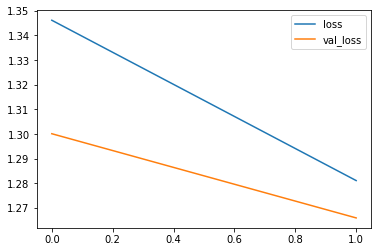

In [22]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

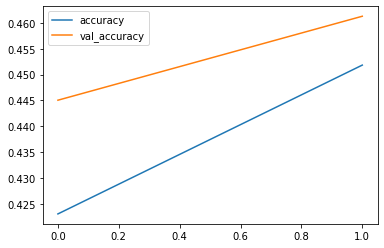

In [23]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","val_accuracy"])

In [25]:
model.evaluate(
    x=[test_user,test_movie],
    y=test_y,
    batch_size=1024,
    )

303/303 [==============================] - 38s 127ms/step - loss: 1.2650 - accuracy: 0.4592


[1.2649627923965454, 0.45918500423431396]

In [26]:
y_pred=np.argmax(model.predict([test_user, test_movie]),axis=1)

9675/9675 [==============================] - 80s 8ms/step


In [ ]:
train_y.value_counts()

3    20703
2    16052
4    12849
1     6778
0     3602
Name: rating, dtype: int64

In [ ]:
test_y.value_counts()

3    15891
2    12362
4    10005
1     5139
0     2745
Name: rating, dtype: int64

In [ ]:
y_pred

array([3, 2, 1, ..., 2, 4, 3], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
test_y

0        3
1        2
2        1
3        3
4        4
        ..
46137    4
46138    2
46139    2
46140    4
46141    3
Name: rating, Length: 46142, dtype: int64

In [ ]:
print(classification_report(y_pred=y_pred,y_true=test_y))

              precision    recall  f1-score   support

           0       0.55      0.20      0.30      2745
           1       0.36      0.09      0.14      5139
           2       0.37      0.50      0.43     12362
           3       0.43      0.58      0.49     15891
           4       0.48      0.28      0.36     10005

    accuracy                           0.42     46142
   macro avg       0.44      0.33      0.34     46142
weighted avg       0.43      0.42      0.40     46142

